# Experiment - Gender Prediction
* StellarAlgo Data Science
* March 24, 2023
* Grant Donst, Peter Morrison

In [1]:
import pandas as pd
import os

from data_sci_toolkit.aws_tools import redshift_tools
from pycaret.classification import *

import gender_guesser.detector as gender

# Load in Data

Running query to gather first name, gender, and other possible features from cohortcustomer, cohortmerch, and cohortconcession

In [2]:
query = """
select cc.gender, cc.dimcustomermasterid, cc.lkupclientid, cc.namefirst, cc.income, cc.education, cc.occupation, cc.monetary_tier_overall, cc.engagementbucket, cc.loyaltypointbalance, cc.isgamer, cm.itemdescription, cm.itemcount, cm.itemrevenue, ccon.purchasecount, ccon.totalspent
from dw.cohortcustomer cc 
	left join dw.cohortmerch cm on cc.dimcustomermasterid = cm.dimcustomermasterid 
	left join dw.cohortconcession ccon on cc.dimcustomermasterid = ccon.dimcustomermasterid 
where cc.gender is not null 
and cc.namefirst is not null;
"""

cluster = "prod-app"
database = "stlrtrailblazers"

In [3]:
conn = redshift_tools.get_redshift_connection(cluster, database)

cur = conn.cursor()
cur.execute(query)

data = cur.fetchall()

cols = [row[0] for row in cur.description]
df = pd.DataFrame(data=data, columns=cols)

conn.close()

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

TPSJ-JTXS
Successfully logged into Start URL: https://stellaralgo.awsapps.com/start#/
Authorized as AROASQ4JELIXYLYV6P4UV:pmorrison@stellaralgo.com


In [4]:
df_temp = df

In [5]:
df_temp.shape

(1658257, 16)

# Pre-Processing

We will preprocess the data, so we can have a predicted score of their gender and clean other data.

In [6]:
gdectect = gender.Detector()

In [7]:
df_temp["name_gender_predict"] = df_temp["namefirst"].apply(gdectect.get_gender)

In [8]:
df_temp.name_gender_predict.value_counts()

male             638307
female           631747
unknown          222049
mostly_female     85519
mostly_male       66898
andy              13737
Name: name_gender_predict, dtype: int64

In [9]:
df_temp["totalspent"] = df_temp["totalspent"].fillna(0)
df_temp["income"] = df_temp["income"].fillna(0)

In [10]:
df_temp["itemcount"] = df_temp["itemcount"].fillna(0)

In [11]:
df_temp["gender"] = df_temp["gender"].apply(lambda x: x.lower())

In [12]:
df_temp["gender"].value_counts()

female    836412
male      821726
o            119
Name: gender, dtype: int64

# Train Model

In [13]:
setup(
    data=df_temp,
    target='gender',
    train_size=0.85,
    data_split_shuffle=True,
    silent=True,
    verbose=False,
    ignore_features=["dimcustomermasterid", "lkupclientid", "namefirst", "itemdescription"],
    numeric_features=["totalspent", "income"]
)

(None,
 10,
 [('Setup Config',
                                  Description                     Value
   0                               session_id                      2731
   1                                   Target                    gender
   2                              Target Type                Multiclass
   3                            Label Encoded  female: 0, male: 1, o: 2
   4                            Original Data             (1658257, 17)
   5                           Missing Values                      True
   6                         Numeric Features                         2
   7                     Categorical Features                         6
   8                         Ordinal Features                     False
   9                High Cardinality Features                     False
   10                 High Cardinality Method                      None
   11                   Transformed Train Set             (1409518, 48)
   12                    Transfor

In [14]:
model_matrix = compare_models(
    fold=2,
    include= ["lightgbm", "catboost", "rf", "svm", "xgboost", "mlp"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9050,0.9653,0.6033,0.9051,0.9049,0.8099,0.8102,32.3100
xgboost,Extreme Gradient Boosting,0.9050,0.9654,0.6033,0.9051,0.9049,0.8099,0.8101,128.6400
lightgbm,Light Gradient Boosting Machine,0.9049,0.9654,0.6032,0.9051,0.9048,0.8097,0.8100,13.2450
rf,Random Forest Classifier,0.9032,0.9624,0.6021,0.9033,0.9032,0.8064,0.8066,14.9000
mlp,MLP Classifier,0.5641,0.6118,0.3736,0.7211,0.4664,0.1217,0.2321,85.1100
svm,SVM - Linear Kernel,0.5625,0.0000,0.3725,0.7338,0.4609,0.1184,0.2354,56.7150


In [15]:
best_model = create_model(model_matrix, fold=2);

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9048,0.9653,0.6032,0.9051,0.9048,0.8096,0.8099
1,0.9051,0.9654,0.6034,0.9052,0.9051,0.8102,0.8104
Mean,0.9050,0.9653,0.6033,0.9051,0.9049,0.8099,0.8102
Std,0.0002,0.0001,0.0001,0.0001,0.0002,0.0003,0.0002


In [16]:
best_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9051,0.9651,0.6034,0.9053,0.9051,0.8102,0.8105
1,0.9056,0.9658,0.6037,0.9057,0.9055,0.8111,0.8113
2,0.9049,0.9650,0.6032,0.9051,0.9049,0.8098,0.8100
3,0.9039,0.9650,0.6026,0.9041,0.9039,0.8078,0.8080
4,0.9049,0.9660,0.6032,0.9051,0.9049,0.8098,0.8101
5,0.9053,0.9656,0.6035,0.9054,0.9052,0.8105,0.8107
6,0.9060,0.9654,0.6040,0.9061,0.9059,0.8119,0.8121
7,0.9049,0.9656,0.6032,0.9050,0.9048,0.8097,0.8099
8,0.9048,0.9652,0.6031,0.9048,0.9047,0.8095,0.8096


In [17]:
final_model = finalize_model(best_model)

/Users/petermorrison/miniforge3/envs/stellar/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/petermorrison/miniforge3/envs/stellar/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/petermorrison/miniforge3/envs/stellar/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Use

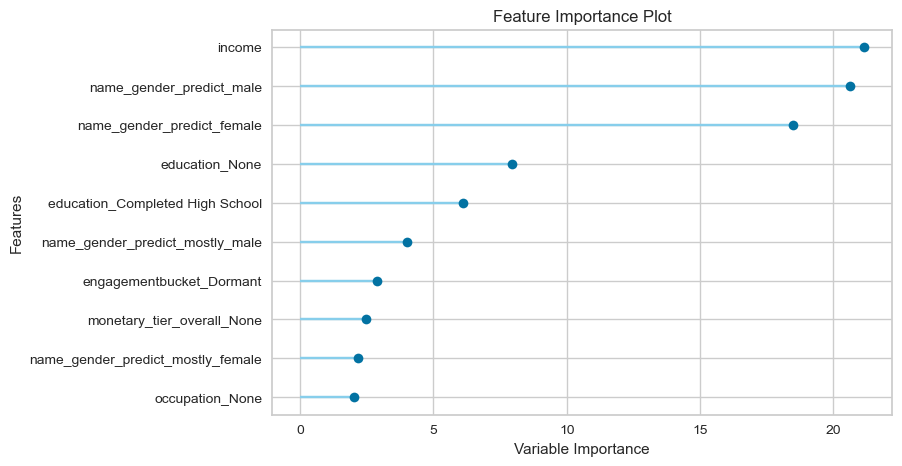

In [18]:
plot_model(best_model, plot="feature")

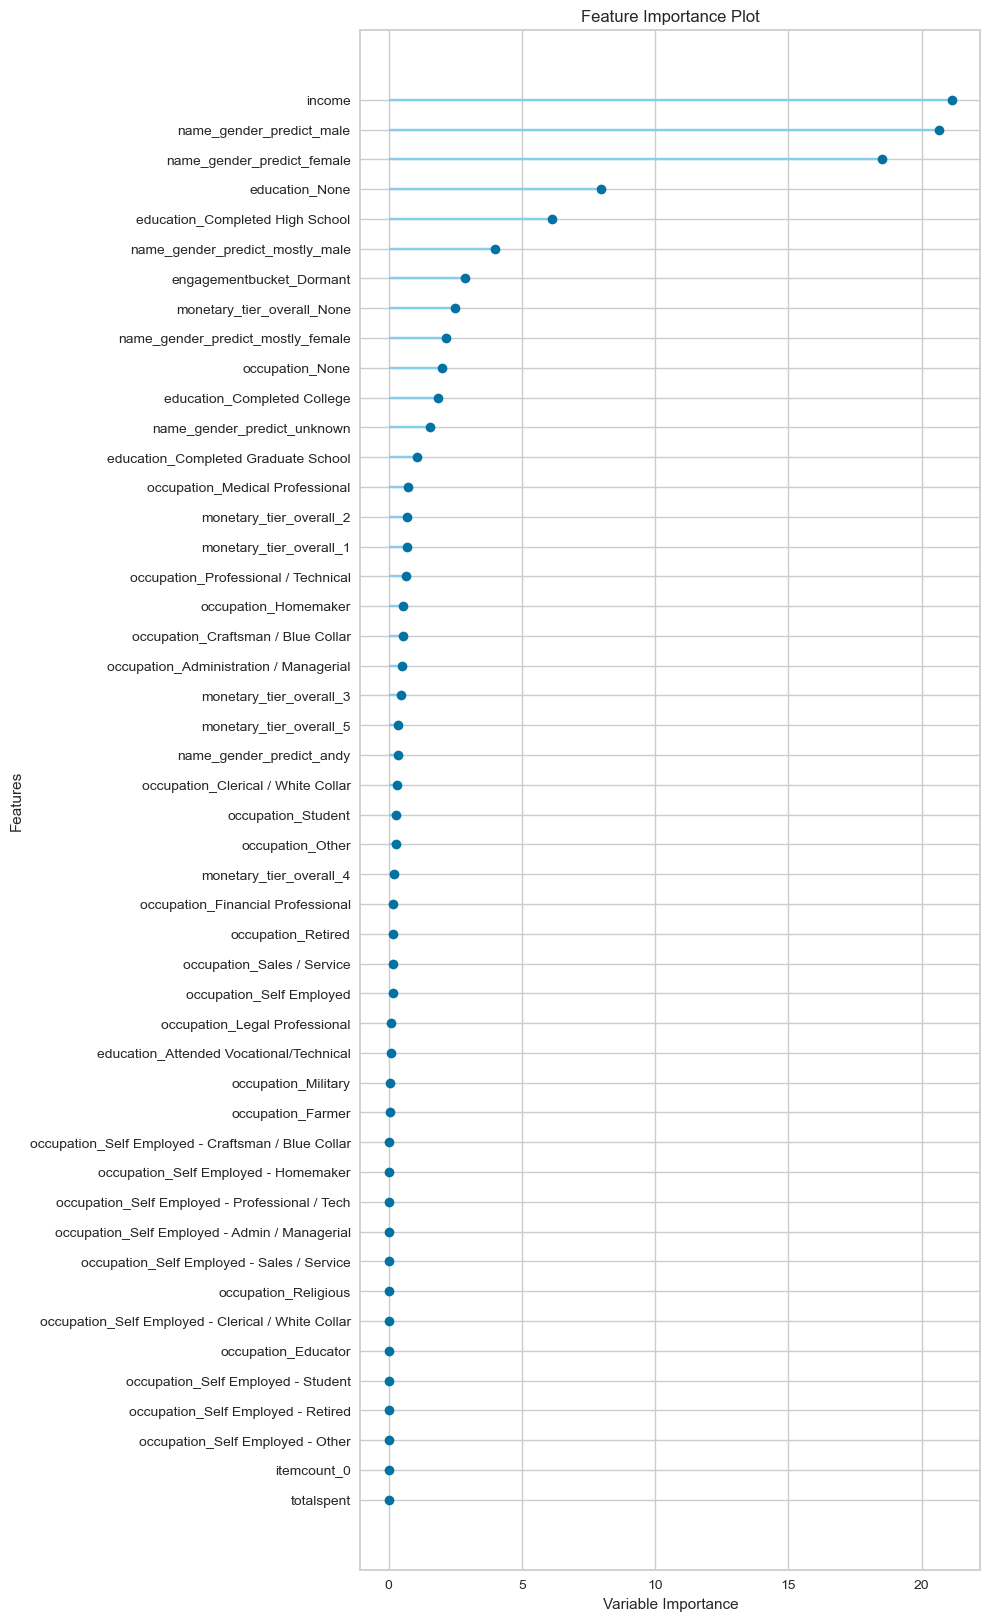

In [19]:
plot_model(best_model, plot="feature_all")

In [20]:
predict_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.9059,0,0.6039,0.9060,0.9058,0.8118,0.8120


,income,totalspent,education_Attended Vocational/Technical,education_Completed College,education_Completed Graduate School,education_Completed High School,education_None,occupation_Administration / Managerial,occupation_Clerical / White Collar,occupation_Craftsman / Blue Collar,...,itemcount_0,name_gender_predict_andy,name_gender_predict_female,name_gender_predict_male,name_gender_predict_mostly_female,name_gender_predict_mostly_male,name_gender_predict_unknown,gender,Label,Score
0,124999.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,male,male,0.5164
1,124999.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,male,female,0.8112
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,female,female,0.9678
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,female,male,0.9644
4,62500.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,male,male,0.9798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248734,87500.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,female,female,0.7284
248735,87500.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,female,female,0.9901
248736,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,female,female,0.7965
248737,124999.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,female,female,0.6977


# Inference Tests

The value of unknowns shows that the inherent bias of the model is roughly 20% skew to male. If there is no name (unknown name) it will predict male with 70% confidence.

unknown	male	0.702979

In [21]:
query = """
select cc.gender, cc.dimcustomermasterid, cc.lkupclientid, cc.namefirst, cc.income, cc.education, cc.occupation, cc.monetary_tier_overall, cc.engagementbucket, cc.loyaltypointbalance, cc.isgamer, cm.itemdescription, cm.itemcount, cm.itemrevenue, ccon.purchasecount, ccon.totalspent
from dw.cohortcustomer cc 
	left join dw.cohortmerch cm on cc.dimcustomermasterid = cm.dimcustomermasterid 
	left join dw.cohortconcession ccon on cc.dimcustomermasterid = ccon.dimcustomermasterid 
where cc.gender is null;
"""

cluster = "prod-app"
database = "stlrtrailblazers"

In [22]:
conn = redshift_tools.get_redshift_connection(cluster, database)

cur = conn.cursor()
cur.execute(query)

data = cur.fetchall()

cols = [row[0] for row in cur.description]
df = pd.DataFrame(data=data, columns=cols)

conn.close()

Authorized as AROASQ4JELIXYLYV6P4UV:pmorrison@stellaralgo.com


In [23]:
inference_name = df

In [24]:
inference_name.shape

(1343537, 16)

### Pre-Processing

We will preprocess the data, so we can have a predicted score of their gender and clean other data.

In [25]:
gdectect = gender.Detector()

In [26]:
inference_name["name_gender_predict"] = inference_name["namefirst"].apply(gdectect.get_gender)

In [27]:
inference_name.name_gender_predict.value_counts()

male             532022
female           416710
unknown          253911
mostly_male       65765
mostly_female     57249
andy              17880
Name: name_gender_predict, dtype: int64

In [28]:
inference_name["totalspent"] = inference_name["totalspent"].fillna(0)

In [29]:
inference_name["itemcount"] = inference_name["itemcount"].fillna(0)

In [30]:
inference_name = inference_name.drop(columns=["gender"], axis=1)

In [31]:
name_results = predict_model(final_model, inference_name)

In [34]:
name_results.groupby(["name_gender_predict", "Label"]).agg({"Score":"mean"})

Score
name_gender_predict Label           
andy                female  0.529246
                    male    0.527497
female              female  0.968996
male                male    0.964050
mostly_female       female  0.724649
mostly_male         male    0.905975
unknown             female  0.542364
                    male    0.568487

# Train with Smote

The results of the compare model below, shows that smote does not help improve over non-smote implementation

In [ ]:
setup(
    data=df_temp,
    target='gender',
    train_size=0.85,
    data_split_shuffle=True,
    silent=True,
    verbose=False,
    fix_imbalance=True,
    ignore_features=["dimcustomermasterid", "lkupclientid", "namefirst", "itemdescription"],
    numeric_features=["totalspent"]
)

In [36]:
smote_model_matrix = compare_models(
    fold=2,
    include= ["lightgbm", "catboost", "rf", "svm", "xgboost"]
)

# Train without Name Data

We wanted to determine if name_gender_predict is the most important factor in predicting a persons gender.

The result of this test is that the accuracy is worse than randomly guessing without the name_gender_predict feature.

In [32]:
setup(
    data=df_temp,
    target='gender',
    train_size=0.85,
    data_split_shuffle=True,
    silent=True,
    verbose=False,
    ignore_features=["dimcustomermasterid", "lkupclientid", "namefirst", "itemdescription", "name_gender_predict"],
    numeric_features=["totalspent"]
)

(None,
 10,
 [('Setup Config',
                                  Description                     Value
   0                               session_id                      6496
   1                                   Target                    gender
   2                              Target Type                Multiclass
   3                            Label Encoded  female: 0, male: 1, o: 2
   4                            Original Data             (1658257, 17)
   5                           Missing Values                      True
   6                         Numeric Features                         1
   7                     Categorical Features                         6
   8                         Ordinal Features                     False
   9                High Cardinality Features                     False
   10                 High Cardinality Method                      None
   11                   Transformed Train Set             (1409518, 51)
   12                    Transfor

In [33]:
smote_model_matrix = compare_models(
    fold=2,
    include= ["lightgbm", "catboost", "rf", "svm", "xgboost", "dummy"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.5652,0.5964,0.3769,0.5654,0.5651,0.1307,0.1308,14.4850
xgboost,Extreme Gradient Boosting,0.5648,0.5960,0.3767,0.5650,0.5647,0.1299,0.1300,131.6800
catboost,CatBoost Classifier,0.5647,0.5959,0.3766,0.5649,0.5645,0.1296,0.1297,28.5100
rf,Random Forest Classifier,0.5620,0.5913,0.3748,0.5623,0.5618,0.1243,0.1245,16.0600
svm,SVM - Linear Kernel,0.5501,0.0000,0.3661,0.5517,0.5439,0.0984,0.1009,3.4400
dummy,Dummy Classifier,0.5044,0.5000,0.3333,0.2544,0.3382,0.0000,0.0000,0.9850


# Train with only name_gender_predict


In [ ]:
setup(
    data=df_temp,
    target='gender',
    train_size=0.85,
    data_split_shuffle=True,
    silent=True,
    verbose=False,
    ignore_features=['dimcustomermasterid', 'lkupclientid', 'namefirst', 'income',
       'education', 'occupation', 'monetary_tier_overall', 'engagementbucket',
       'loyaltypointbalance', 'isgamer', 'itemdescription', 'itemcount',
       'itemrevenue', 'purchasecount', 'totalspent']
)

In [ ]:
smote_model_matrix = compare_models(
    fold=2,
    include= ["lightgbm", "catboost", "rf", "svm", "xgboost", "dummy", "lr"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8744,0.9073,0.5683,0.8664,0.8698,0.7063,0.7078,0.0800
catboost,CatBoost Classifier,0.8744,0.9073,0.5683,0.8664,0.8698,0.7063,0.7078,1.0700
rf,Random Forest Classifier,0.8744,0.9073,0.5683,0.8664,0.8698,0.7063,0.7078,0.1100
svm,SVM - Linear Kernel,0.8744,0.0000,0.5683,0.8664,0.8698,0.7063,0.7078,0.0200
xgboost,Extreme Gradient Boosting,0.8744,0.9073,0.5683,0.8664,0.8698,0.7063,0.7078,0.3300
lr,Logistic Regression,0.8744,0.9073,0.5683,0.8664,0.8698,0.7063,0.7078,0.0500
dummy,Dummy Classifier,0.6789,0.5000,0.3333,0.4610,0.5491,0.0000,0.0000,0.0150
